In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# export
import torch
from torch import nn
import torch.nn.functional as F
from typing import Dict, List

#export

dilation = 1, stride = 1 :$$H_{out}=\lfloor\frac{H_{in}+2p-k+1}{stride}\rfloor$$ then p = k // 2 so that $$H_{out}=\lfloor\frac{H_{in}}{stride}\rfloor$$

dilation = 1, kernel = 5  stride = 2 :
$$H_{out}=\lfloor\frac{H_{in}+2p-3}{stride}\rfloor$$
I choose p= k// 2 = 2 ,  we need to verify that H remains divisable
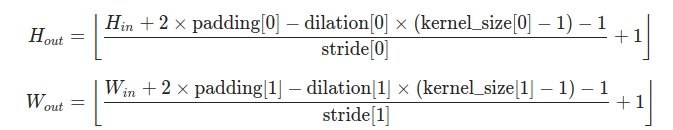

In [16]:
# export
class Cs:
    """Consts for encoder"""
    in_channels_to_conv2d_1= 3
    n = 128
    quantizer_num_of_centers = 32
    use_heat_map = True
    
    basic_conv2d={'padding_mode':'replicate'}
    padding_stride2_kernel5={'kernel_size': [5,5],'stride': [2,2],'padding':[2,2]}
    padding_stride1_kernel3={'kernel_size': [3,3],'stride': [1,1],'padding':[1,1]}
    
    enc_conv2d_1={'in_channels': in_channels_to_conv2d_1,
                  'out_channels': n // 2,
                  **padding_stride2_kernel5,
                  **basic_conv2d}
    enc_conv2d_2={'in_channels': n // 2, 'out_channels': n,
                  **padding_stride2_kernel5,
                  **basic_conv2d}
    
    enc_resblock={'in_channels': n , 'out_channels': n,
                  **padding_stride1_kernel3,
                  **basic_conv2d}
    
    enc_uber_resblock={'num_of_resblocks':3, 'enc_resblock':enc_resblock}
    enc_uber_resblocks={'num_of_uberresblocks': 5, 'enc_uber_resblock':enc_uber_resblock}
    last_conv2d_out =  \
        quantizer_num_of_centers + 1 if use_heat_map else quantizer_num_of_centers
    
    last_conv2d={'in_channels': n,
                 'out_channels': last_conv2d_out,
                  **padding_stride2_kernel5,
                  **basic_conv2d}
    
    

In [12]:

class Encoder(nn.Module):
    def __init__(self,conv2d_1: Dict,
                      convs2d_2: Dict,
                      uberresblocks: Dict,
                      prelast_resblock: Dict,
                      last_conv2d: Dict):
        super().__init__()
        layers = []
        
        for i in range(uberresblocks['num_of_uberresblocks']):
            layers.append(UberResBlock(**uberresblocks['enc_uber_resblock']))
        layers.append(ResBlock(**prelast_resblock))
        
        self.pre_sum_model = nn.Sequential(*layers)
        self.post_sum_model= nn.Conv2d(**last_conv2d)
        
    @staticmethod
    def create_module_from_const():
        return Encoder(Cs.enc_conv2d_1,
                       Cs.enc_conv2d_2,
                       Cs.enc_uber_resblocks,
                       Cs.enc_uber_resblocks['enc_uber_resblock']['enc_resblock'],
                       Cs.last_conv2d)
                      
                      
                      
    
    def forward(self, x):
        res_pre_conv = self.pre_sum_model(x) + x
        return self.post_sum_model(res_pre_conv)
    
class UberResBlock(nn.Module):
    
    def __init__(self,num_of_resblocks: int, enc_resblock: Dict):
        super().__init__()
        layers = []
        for i in range(num_of_resblocks):
            layers.append(ResBlock(**enc_resblock))
            
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x) + x

class ResBlock(nn.Module):
    NUM_OF_CONVS = 2 
    def __init__(self,in_channels: int, out_channels: int, kernel_size: List,
                 stride: List,padding_mode: str,padding, num_of_convs: int = NUM_OF_CONVS):
        super().__init__()
        layers = []
        for i in range(num_of_convs):
            layers.append(nn.Conv2d(in_channels,out_channels,kernel_size))
            if i==0:
                layers.append(nn.ReLU())

        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x) + x
    

    

In [13]:

x = Encoder.create_module_from_const()

print(x)

Encoder(
  (pre_sum_model): Sequential(
    (0): UberResBlock(
      (model): Sequential(
        (0): ResBlock(
          (model): Sequential(
            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1))
            (1): ReLU()
            (2): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1))
          )
        )
        (1): ResBlock(
          (model): Sequential(
            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1))
            (1): ReLU()
            (2): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1))
          )
        )
        (2): ResBlock(
          (model): Sequential(
            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1))
            (1): ReLU()
            (2): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1))
          )
        )
      )
    )
    (1): UberResBlock(
      (model): Sequential(
        (0): ResBlock(
          (model): Sequential(
            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1))
         

In [8]:
#export
class Decoder(nn.Module):
    pass

In [ ]:
torch.nn.ConvTranspose2d
torch.nn.ReplicationPad2d(